# Resonant whistler-electron interactions: MMS observations
___
![illustration](graphics/illustration_nb_1.png)
___
The following code creates all electron Velocity Distribution Functions (VDF) provided in the manuscript [Resonant whistler-electron interactions: MMS observations vs. test-particle simulation](https://arxiv.org/abs/2004.09130).

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
import warnings
warnings.filterwarnings('ignore')

## Regular <code>aidapy</code> setup
As usual, we first import the data loading utilities (<code>aidapy</code> and <code>heliopy</code>) and the xarray classes/accessors.

In [2]:
from aidapy import load_data

This case study focuses on one time interval on the 8th of March 2019, when the probes were in the magnetosheath, very close to the magnetopause.

In [3]:
start_time = datetime(2019, 3, 8, 13, 54, 53)
end_time   = datetime(2019, 3, 8, 13, 57, 0)

This notebook focuses on the particles' results of the manuscript, however we still need to load some magnetic field data in order to work in a B-aligned frame of reference. The bulk velocity of the ions is also used to translate the data to the estimated plasma frame, the frame in which the bulk velocity of all particles is 0 m/s.

In [4]:
settings = {'prod': ['i_dist', 'e_dist', 'dc_mag', 'sc_att', 'i_bulkv'],
            'probes': ['1'], 'coords': 'gse', 'mode': 'high_res', 'frame':'gse'}

We now load the data (either complete downloading from the MMS repository, or a simple access to local files):

In [5]:
xr_mms = load_data(mission='mms', start_time=start_time, end_time=end_time, **settings)

## The case study
### Setting the interpolation

For now we focuse on electrons, using a spherical interpolation grid defined below with the folowing parameters. We use a reduced resolution and a nearest-neighbour interpolation scheme for time efficiency.
___
***Note***: the figures shown in the manuscript are using resolution between 120 and 200, and a tricubic interpolation scheme (used for shorter time intervals below).
___

In [6]:
species      = 'electron'
frame        = 'B'
grid_geom    = 'spher'
v_max        = 1.2e7
resolution   = 80
interp_schem = 'near'

We first select the largest time sub-interval, corresponding to the duration of the spectrograms in the manuscript, for a global over-view. We can 

In [7]:
start_time_sub = datetime(start_time.year, start_time.month, start_time.day, 13, 56, 14, 0)
end_time_sub   = datetime(start_time.year, start_time.month, start_time.day, 13, 56, 34, 0)

In [8]:
xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem)



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    spher
| Resolution:       80
| Interpolation:    near
| Start time:       2019-03-08T13:56:14.006215000
| Stop time :       2019-03-08T13:56:34.016448000
| Ind. start-stop:  2700-3367
| Nb distributions: 667
|____________________________________________________________


3360/4234 (current VDF/nb total VDFs)
Total runtime: 64 s.



We see here above that a total of 667 electron VDFs were interpolated.

### Overall visualisations: scaled-pitch angle distribution.

Before looking at specific sub-intervals, we retain the time dimension and use the scaled pitch-angle distribution provided by <code>graphical.vdf_spher_time()</code>


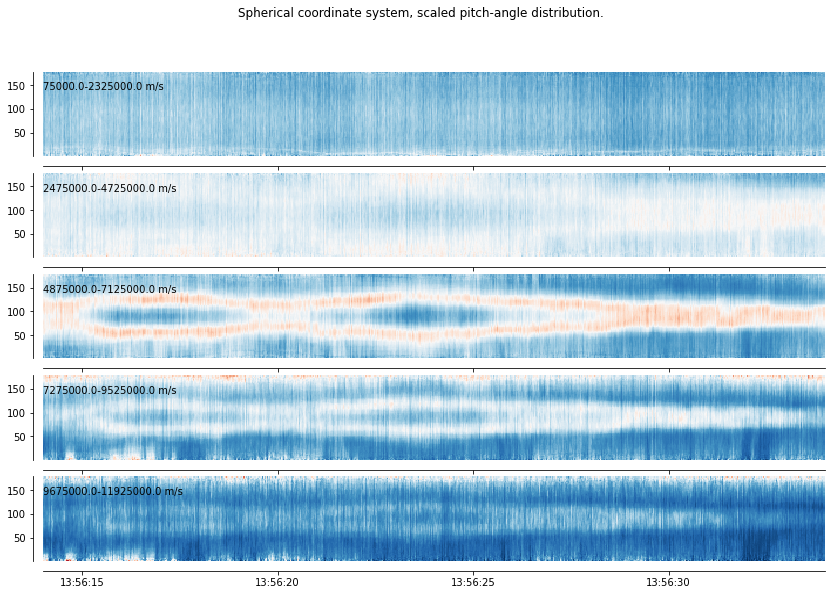

In [9]:
xr_mms.vdf.plot('3d_time', plt_contourf=False)

However, only one speed interval is shown in the manuscript, namely the interval $[5.8, 6.3]\, 10^6$ m/s. This can be re-created manually by first finding out to which indices <code>ind_min</code> and <code>ind_max</code> along the speed dimension these values correspond:

In [10]:
speed = xr_mms['grid_interp_spher'].values[0,:,0,0]
ind_min = np.where(speed>5.8e6)[0][0]
ind_max = np.where(speed<6.3e6)[0][-1]
print(ind_min, ind_max, speed.shape)

39 41 (80,)


We find that for values along the speed dimension with indices between 58 and 62 in the interpolated VDF, particles have a speed in the desired range. We can therefore average the scaled VDF along this dimension using these indices:

In [11]:
vdf_scaled = xr_mms['vdf_scaled_time'].values
scaled_pa_distrib = np.nanmean(vdf_scaled[:,ind_min:ind_max,:], axis=(1))

We quickly plot this scaled pitch-angle distribution to reproduce the manuscript figure.

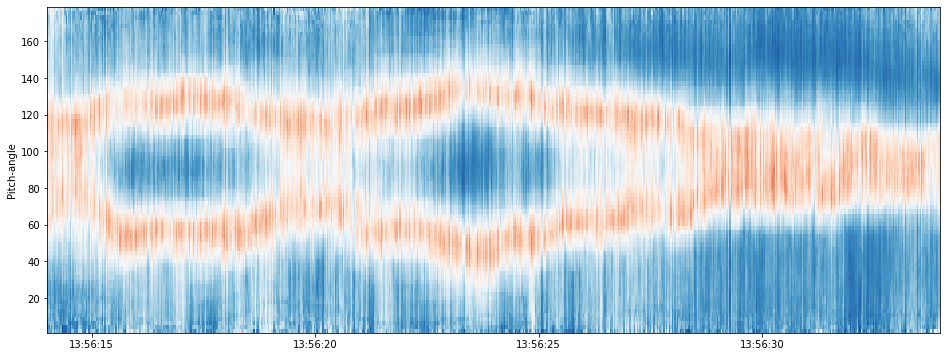

In [12]:
time_interp = xr_mms['time_interp'].values
pa = xr_mms['grid_interp_spher'].values[1,0,:,0]

fig, ax = plt.subplots(figsize=(16,6))

ax.pcolormesh(time_interp, pa*180/np.pi, scaled_pa_distrib.T, vmin=0., vmax=1., cmap='RdBu_r', rasterized=True)
ax.set_ylabel('Pitch-angle')
plt.savefig('yo.pdf')
plt.show()

### Local VDFs

We now use shorter time intervals to reproduce the figures of the manuscript. A higher resolution is used, together with the tricubic scheme.


In [13]:
resolution   = 120
interp_schem = 'cub'
v_max        = 1.1e7



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    spher
| Resolution:       120
| Interpolation:    cub
| Start time:       2019-03-08T13:56:23.186320000
| Stop time :       2019-03-08T13:56:23.246320000
| Ind. start-stop:  3006-3008
| Nb distributions: 2
|____________________________________________________________



Total runtime: 7 s.



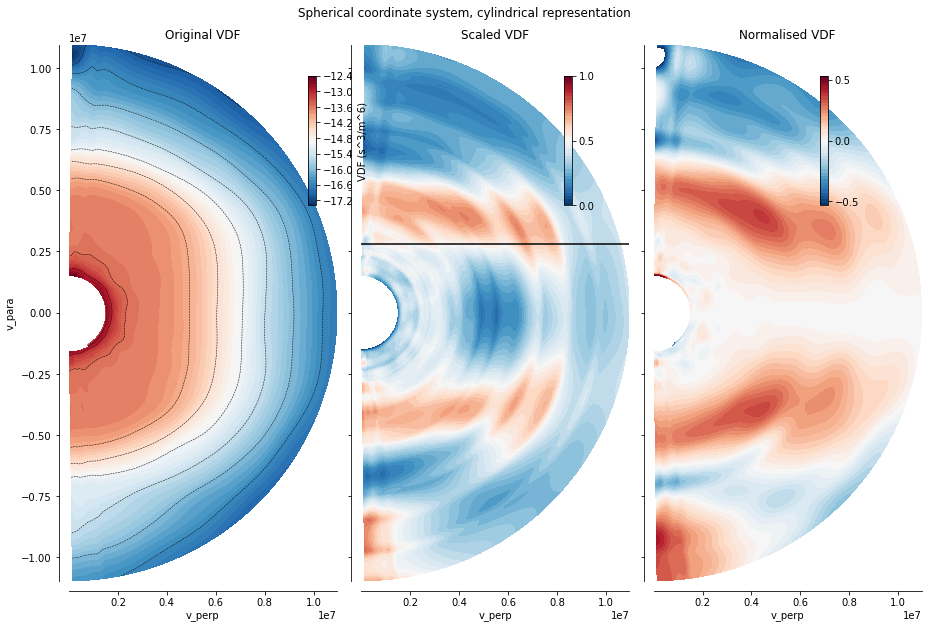

In [14]:
# Figure 4.
start_time_sub = datetime(start_time.year, start_time.month, start_time.day, 13, 56, 23, 160000)
end_time_sub   = datetime(start_time.year, start_time.month, start_time.day, 13, 56, 23, 225000)

xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem)
xr_mms.vdf.plot('2d', plt_contourf=True)



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    spher
| Resolution:       120
| Interpolation:    cub
| Start time:       2019-03-08T13:56:23.906320000
| Stop time :       2019-03-08T13:56:24.206330000
| Ind. start-stop:  3030-3040
| Nb distributions: 10
|____________________________________________________________


3030/4234 (current VDF/nb total VDFs)
Total runtime: 37 s.



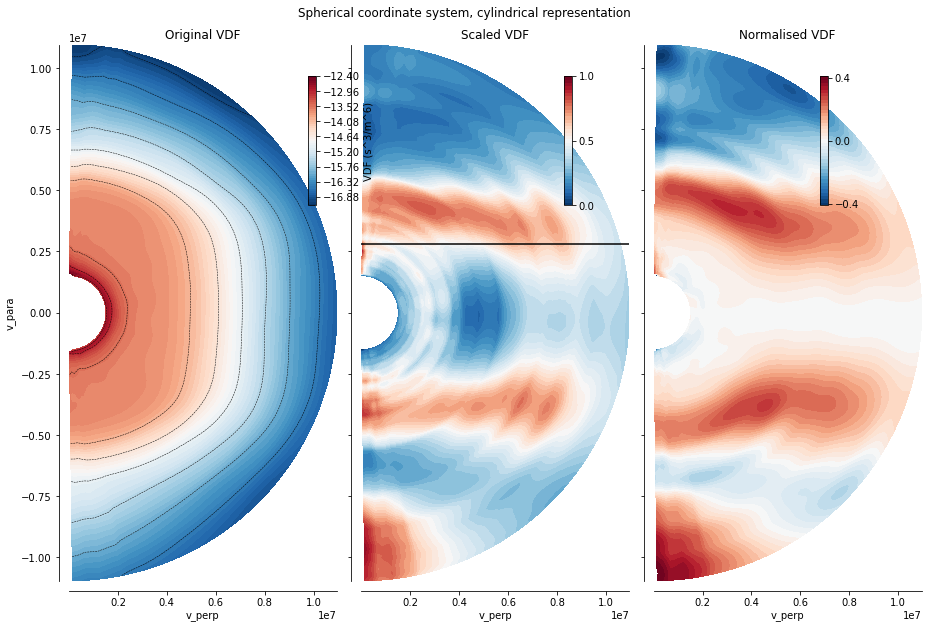

In [15]:
# Figure 5-c
start_time_sub = datetime(start_time.year, start_time.month, start_time.day, 13, 56, 23, 906000)
end_time_sub   = datetime(start_time.year, start_time.month, start_time.day, 13, 56, 24, 206000)

xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem)
xr_mms.vdf.plot('2d', plt_contourf=True)



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    spher
| Resolution:       120
| Interpolation:    cub
| Start time:       2019-03-08T13:56:33.506435000
| Stop time :       2019-03-08T13:56:33.806435000
| Ind. start-stop:  3350-3360
| Nb distributions: 10
|____________________________________________________________


3350/4234 (current VDF/nb total VDFs)
Total runtime: 37 s.



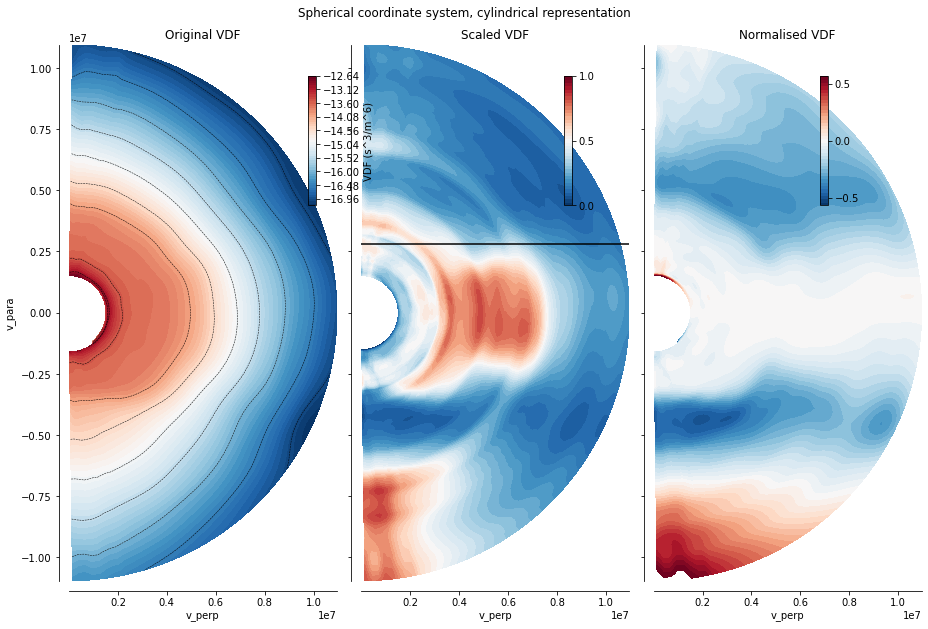

In [16]:
# Figure 5-d
start_time_sub = datetime(start_time.year, start_time.month, start_time.day, 13, 56, 33, 506000)
end_time_sub   = datetime(start_time.year, start_time.month, start_time.day, 13, 56, 33, 806000)

xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem)
xr_mms.vdf.plot('2d', plt_contourf=True)